test:
1. get embedding
2. get discriminator
3. get off-manifolder
4. get jacobian of the chain
5. visualize jacobians

In [2]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
# from diffusion import DiffusionModel
# from evaluate import get_results
from omegaconf import OmegaConf
# from main import load_data, make_model
import numpy as np
import os
import glob
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import torch
from model2 import Autoencoder, Preprocessor, WDiscriminator
from off_manifolder import offmanifolder1_maker, offmanifolder2_maker
import magic
import torch
import pathlib
import copy

import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
from omegaconf import OmegaConf
import os
import glob
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from geodesic import jacobian, velocity, CondCurve, GeodesicBridgeOverfit, GeodesicBridge
from plotly3d.plot import scatter, trajectories
import torch
from torch import nn
import pytorch_lightning as pl
from procrustes import Procrustes
from torch.utils.data import DataLoader, TensorDataset

In [98]:
main_sweep_id = '59muwbsf'
main_disc_sweep_id = 'g0066w8g'
main_data_name = 'hemisphere_none_0'
main_weights_cycle = 1.
main_dimensions_latent = 3

wandb.login()
api = wandb.Api()

entity = "xingzhis"
project = "dmae"
sweep_id = main_sweep_id
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
# Initialize an empty list to store run data
runs_data = []

# Iterate through each run in the sweep
for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)

data_name = main_data_name
# run_ids = df[(df['data.name'] == data_name) & (df['cfg/loss/weights/cycle'] == 1.) & (df['cfg/dimensions/latent'] == 3)]['run_id']
run_ids = df[(df['data.name'] == data_name) & (df['loss.weights.cycle'] == main_weights_cycle) & (df['dimensions.latent'] == main_dimensions_latent)]['run_id']
assert len(run_ids) == 1
run_id = run_ids.iloc[0]
run = api.run(f"{entity}/{project}/{run_id}")
# run = api.run(f"{entity}/{project}/{run_id}")
folder_path = '../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
# cfg.data.root = '../' + cfg.data.root
model = Autoencoder.load_from_checkpoint(ckpt_path)
data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    model.eval()
    x = torch.tensor(data['data'], dtype=torch.float32, device=model.device)
    z = model.encoder(x)
    xh = model.decoder(z)
    zhh = model.encoder(xh)
zc = z.cpu().numpy()
# fig = scatter(zc, s=2, alpha=0.2, title='latent', filename=f'{results_path}/latent.html')
# wandb.log({"latent": wandb.Plotly(fig)})
# fig = scatter(zhh, s=2, alpha=0.2, title='latent_reembedd', filename=f'{results_path}/latent_reembedded.html')
# wandb.log({"latent_reembedded": wandb.Plotly(fig)})
# fig = scatter(x, s=2, alpha=0.2, title='data', filename=f'{results_path}/data.html')
# wandb.log({"data": wandb.Plotly(fig)})
# fig = scatter(xh, s=2, alpha=0.2, title='reconstruction', filename=f'{results_path}/reconstruction.html')
# wandb.log({"reconstruction": wandb.Plotly(fig)})

sweep_id = main_disc_sweep_id
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
# Initialize an empty list to store run data
runs_data = []

# Iterate through each run in the sweep
for run in sweep.runs:
    # Extract metrics and configs
    metrics = run.summary._json_dict
    configs = run.config
    
    # Combine metrics and configs, and add run ID
    combined_data = {**metrics, **configs, "run_id": run.id}
    
    # Append the combined data to the list
    runs_data.append(combined_data)

# Create a DataFrame from the runs data
df = pd.DataFrame(runs_data)
run_ids = df[(df['data.name'] == data_name) & (df['cfg/training/clamp'] == .1)][['run_id']]
assert len(run_ids) == 1
run_id = run_ids.iloc[0]
run = api.run(f"{entity}/{project}/{run_ids.iloc[0].values[0]}")
folder_path = '../src/wandb/'
cfg = OmegaConf.create(run.config)
folder_list = glob.glob(f"{folder_path}*{run.id}*")
ckpt_files = glob.glob(f"{folder_list[0]}/files/*.ckpt")
ckpt_path = ckpt_files[0]
# cfg.data.root = '../' + cfg.data.root
wd = WDiscriminator.load_from_checkpoint(ckpt_path)
data = np.load(f"{cfg.data.root}/{cfg.data.name}{cfg.data.filetype}", allow_pickle=True)
with torch.no_grad():
    wd.eval()
    x_disc = torch.tensor(data['data'], dtype=torch.float32, device=wd.device)
    probab = wd(x_disc).flatten()
    z = model.encoder(x_disc)

# title = f'{data_name} {noise_type} {noise_level} {dist_mask}'
# scatter(zc, data['mask_x'], s=2, alpha=0.2, title=title, filename=filename).show()
# scatter(zhh, data['mask_x'], s=2, alpha=0.2, title=title, filename=filename).show()
scatter(x_disc, data['mask_x'], s=2, alpha=0.2, title=f'{data_name}: input').show()
scatter(x_disc, probab, s=2, alpha=0.2, title=f'{data_name}: probability').show()#, filename='hsphere_disc_prob.html').show()
scatter(x_disc, probab > 0.5, s=2, alpha=0.2, title=f'{data_name}: classification').show()

# if plot_recon:
#     title = f'[RECON] {title}'
#     if savefolder is not None:
#         filename = f"{savefolder}/{title1}.html"
#     # scatter(xh, data['mask_x'], s=2, alpha=0.2, title=title1, filename=filename).show()


/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning:

Attribute 'preprocessor' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocessor'])`.



In [99]:
max_prob = probab.max()

(array([  23., 1001.,  489.,  162.,  127.,   79.,   83.,  153., 1011.,
        2372.]),
 array([-0.90570462, -0.716052  , -0.52639937, -0.33674678, -0.14709418,
         0.04255843,  0.23221104,  0.42186365,  0.61151624,  0.80116886,
         0.99082148]),
 <BarContainer object of 10 artists>)

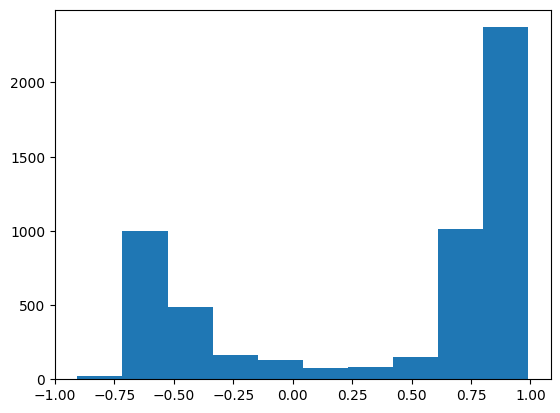

In [100]:
plt.hist(probab)

In [59]:

xbatch = torch.tensor(data['start_points'], dtype=x.dtype, device=x.device)
xendbatch = torch.tensor(data['end_points'], dtype=x.dtype, device=x.device)

xbatch = model.encoder.preprocessor.normalize(xbatch)
xendbatch = model.encoder.preprocessor.normalize(xendbatch)
ids = torch.zeros((xbatch.size(0),1))

dataset = TensorDataset(xbatch, xendbatch, ids)
dataloader = DataLoader(dataset, batch_size=len(z), shuffle=True)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
enc_func = lambda x: model.encoder(x)
disc_func = lambda x: wd(x).flatten()
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
ofm = offmanifolder1_maker(enc_func, disc_func, disc_factor=4)
gbmodel = GeodesicBridgeOverfit(
    func=ofm,
    # func = enc_func,
    # discriminator_func=disc_func,
    # discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-3, 
    weight_decay=1e-5,
    discriminator_weight=0.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=1.,
)

In [13]:
trainer = pl.Trainer(
    max_epochs=200,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
---------------------------------

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


In [14]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()

In [15]:
with torch.no_grad():
    what_flatten = ofm(xflatten)

(array([ 44.,  81., 126.,  54.,  25.,  13.,  14.,  22.,   8.,  13.]),
 array([-3.73766947, -3.02797151, -2.31827354, -1.60857558, -0.89887762,
        -0.18917966,  0.5205183 ,  1.23021626,  1.93991423,  2.64961219,
         3.35931015]),
 <BarContainer object of 10 artists>)

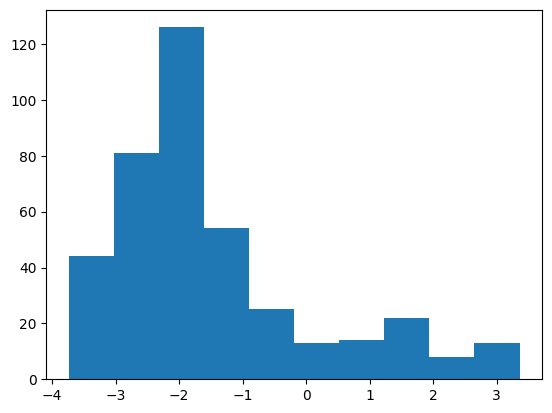

In [18]:
plt.hist(what_flatten[:,-1].cpu().numpy())

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
enc_func = lambda x: model.encoder(x)
disc_func = lambda x: wd(x).flatten()
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
ofm = offmanifolder2_maker(enc_func, disc_func, disc_factor=3)
gbmodel = GeodesicBridgeOverfit(
    func=ofm,
    # func = enc_func,
    # discriminator_func=disc_func,
    # discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-2, 
    weight_decay=1e-5,
    discriminator_weight=0.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=1.,
)

In [25]:
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
------------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [26]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()

In [30]:
def offmanifolder3_maker(
    encoder_, 
    discriminator_, 
    disc_factor = 4,
    folding_dim = 10,
):
    def ofm_(x):
        z = encoder_(x)
        # weighting_factor = discriminator_(x)*disc_factor
        weighting_factor = torch.exp((1-discriminator_(x))*disc_factor) - 1
        rand_pts = torch.rand(z.shape[0], folding_dim - z.shape[1], device=x.device, dtype=torch.float32)
        return torch.cat([z, weighting_factor.reshape(-1,1) * rand_pts], dim=1)
    return ofm_

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
enc_func = lambda x: model.encoder(x)
disc_func = lambda x: wd(x).flatten()
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
ofm = offmanifolder3_maker(enc_func, disc_func, disc_factor=3)
gbmodel = GeodesicBridgeOverfit(
    func=ofm,
    # func = enc_func,
    # discriminator_func=disc_func,
    # discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-2, 
    weight_decay=1e-5,
    discriminator_weight=0.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=1.,
)

In [32]:
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
------------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [33]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()

In [34]:
def offmanifolder4_maker(
    encoder_, 
    discriminator_,
    device,
    disc_factor = 4,
    emb_dim=2,
    folding_dim = 10,
):
    random_matrix = torch.randn(emb_dim, folding_dim - emb_dim, device=device, dtype=torch.float32)
    def ofm_(x):
        z = encoder_(x)
        rand_pts = z @ random_matrix
        # weighting_factor = discriminator_(x)*disc_factor
        weighting_factor = torch.exp((1-discriminator_(x))*disc_factor) - 1
        return torch.cat([z, weighting_factor.reshape(-1,1) * rand_pts], dim=1)
    return ofm_

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
enc_func = lambda x: model.encoder(x)
disc_func = lambda x: wd(x).flatten()
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
ofm = offmanifolder4_maker(enc_func, disc_func, device=device, disc_factor=3, emb_dim=3)
gbmodel = GeodesicBridgeOverfit(
    func=ofm,
    # func = enc_func,
    # discriminator_func=disc_func,
    # discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-2, 
    weight_decay=1e-5,
    discriminator_weight=0.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=1.,
)

In [37]:
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning:

The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_env ...

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning:

Checkpoint directory /gpfs/gibbs/pi

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [38]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
enc_func = lambda x: model.encoder(x)
disc_func = lambda x: wd(x).flatten()
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
ofm = offmanifolder4_maker(enc_func, disc_func, device=device, disc_factor=3, emb_dim=3)
gbmodel = GeodesicBridgeOverfit(
    func=ofm,
    # func = enc_func,
    discriminator_func=disc_func,
    # discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-2, 
    weight_decay=1e-5,
    discriminator_weight=8.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=0.,
)

In [41]:
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
------------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [42]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()

In [101]:
def offmanifolder5_maker(
    encoder_, 
    discriminator_, 
    disc_factor = 4,
    max_prob=1.
):
    def ofm_(x):
        z = encoder_(x)
        weighting_factor1 = (max_prob-discriminator_(x))*disc_factor
        weighting_factor2 = torch.exp(weighting_factor1)
        return torch.cat([z * (weighting_factor2.reshape(-1,1)), (weighting_factor1 * 10).unsqueeze(1).repeat(1, 1)], dim=1)
    return ofm_

In [164]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
wd = wd.to(device)
# discriminator = discriminator.to(device)
for param in model.encoder.parameters():
    param.requires_grad = False
for param in wd.parameters():
    param.requires_grad = False
enc_func = lambda x: model.encoder(x)
disc_func = lambda x: wd(x).flatten()
disc_func_pen = lambda x: 1 - (max_prob - disc_func(x))
discriminator_func_for_grad = lambda x: wd(x)
# discriminator_func_for_grad = lambda x: discriminator.positive_proba(x).reshape(-1,1)
ofm = offmanifolder5_maker(enc_func, disc_func, disc_factor=3, max_prob=max_prob)
gbmodel = GeodesicBridgeOverfit(
    func=ofm,
    # func = enc_func,
    discriminator_func=disc_func_pen,
    discriminator_func_for_grad=discriminator_func_for_grad,
    input_dim=x.size(1), 
    hidden_dim=32, 
    scale_factor=1, 
    symmetric=True, 
    num_layers=2, 
    n_tsteps=20, 
    lr=1e-4, 
    weight_decay=1e-3,
    discriminator_weight=10.,
    discriminator_func_for_grad_weight=0.,
    id_dim=1,
    id_emb_dim=1,
    density_weight=0.,
    length_weight=0.,
)

In [165]:
gbmodel.lr=1e-3
# gbmodel.discriminator_func_for_grad_weight=0.,
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)
gbmodel.lr=1e-3
# gbmodel.discriminator_func_for_grad_weight=1.
gbmodel.multiply_loss = True
trainer = pl.Trainer(
    max_epochs=400,
    log_every_n_steps=20,
    accelerator='cuda',
)
trainer.fit(gbmodel, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
------------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type             | Params
------------------------------------------
0 | cc   | CondCurveOverfit | 7.8 K 
------------------------------------------
7.8 K     Trainable params
0         Non-trainable params
7.8 K     Total params
0.031     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


In [166]:
x0, x1, ids = next(iter(dataloader))
x0 = x0.to(device)
x1 = x1.to(device)
ids = ids.to(device)
x = x.to(device)
gbmodel = gbmodel.to(device)
with torch.no_grad():
    xhat = gbmodel(x0, x1, gbmodel.ts.to(device), ids)

xshape = xhat.shape
xflatten = xhat.flatten(0,1)
with torch.no_grad():
    zhat_flatten = model.encoder(xflatten)
    zhat = zhat_flatten.reshape(xshape[0], xshape[1], -1)
    z0 = model.encoder(x0)
    z1 = model.encoder(x1)

    fig = scatter(model.encoder.preprocessor.normalize(x).cpu().numpy(), s=2)
    fig = scatter(x0.detach().cpu().numpy(), s=10, fig=fig)
    fig = scatter(x1.detach().cpu().numpy(), s=10, fig=fig)
    fig = trajectories(xhat.detach().cpu().numpy(), s=5, fig=fig, title='Geodesic')
    fig.show()